In [23]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [25]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [26]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [102]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("CQA", 1, "bar")


        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bars= self.GenerateBarData(width, height)
            self.add_image("CQA", image_id=i, path=None,
                           width=width, height=height, bars=bars)#,
                          # bg_color=bg_color, shapes=shapes)
                
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bars = info['bars']
        image = np.ones(shape=(info['height'], info['width'], 3))
        image= self.drawImage(image, bars, info['height'],  info['width'])
        return image/255
    
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        bars = info['bars']
        count = len(bars)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (bar_name, _, dims) in enumerate(info['bars']):
 
            mask[:, :, i:i+1] = self.drawImage(mask[:, :, i:i+1].copy(),
                                                [bars[i]], info['height'], info['width'], True)

        
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index('bar') for s in bars])
        return mask.astype(bool), class_ids.astype(np.int32)
        
    
    def GenerateBarData(self, height, width):
    
        min_num_obj = 3
        max_num_obj = 6
        num=np.random.randint(min_num_obj, max_num_obj + 1)
        #todo: change max_obj_num for more bars
        max_obj_num = 6
        colors = np.random.uniform(0.0, 0.9,size = (max_obj_num,3))
        heights = np.random.randint(10,80,size=(num))

        barWidth = int( (width-3*(num+1)-3)//num * (np.random.randint(50,100)/100.0) )
        barWidth = max(barWidth, 4)
        spaceWidth = (width-(barWidth)*num)//(num+1)

        sx = (width - barWidth*num - spaceWidth*(num-1))//2
        bars = []

        for i in range(num):

            sy = width - 1
            ex = sx + barWidth
            ey = sy - heights[i]

            bar_name = 'bar_{}'.format(i)
            bars.append((bar_name, colors[i], (sx, sy, ex, ey)))
            sx = ex + spaceWidth

        return bars
     
    
    def drawImage(self, image, bars, height, width, mask=False):
        
        for bar in bars:
            sx, sy, ex, ey = bar[2]
            if mask== False:
                color = bar[1]
            else:
                color = 1
            cv2.rectangle(image,(sx,sy),(ex,ey),color,-1)
        if mask is False:
            channel  = 3
            noises = np.random.uniform(0, 0.05, (height, width,channel))
            image = image + noises
            _min = 0.0
            _max = image.max()
            image -= _min
            image /= (_max - _min)
        
        return image * 255
        

In [103]:
dataset_train = ShapesDataset()
dataset_train.load_shapes(1000, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

dataset_test = ShapesDataset()
dataset_test.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_test.prepare()

In [108]:
image =dataset_train.load_image(45)

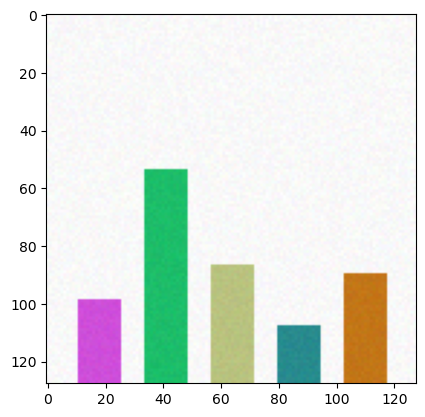

In [109]:
plt.imshow(image)

In [110]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
# load image as pixel array
image = plt.imread('test13.png')

In [ ]:
image.shape

In [ ]:
#import cv2
#image = cv2.resize(image, (128,128))


In [ ]:
plt.imshow(image)

In [14]:
results = model.detect([image], verbose=1)



Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max: -102.90392  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


/home/mahsa.geshvadi001/miniconda3/envs/TF24/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


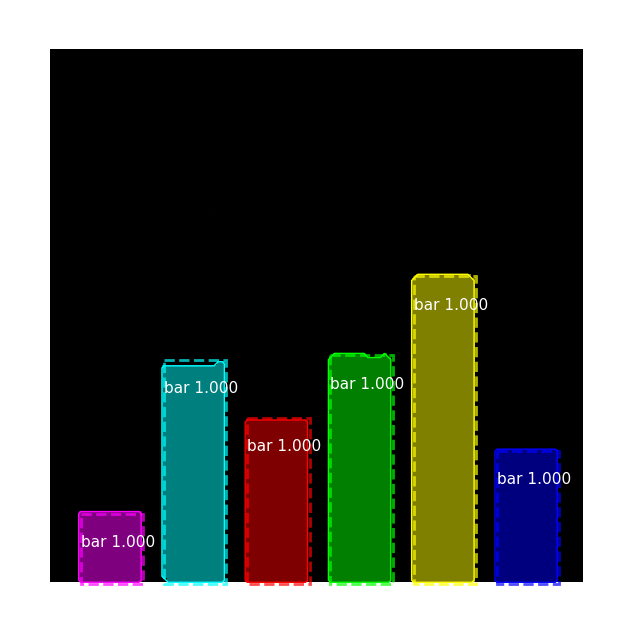

In [15]:
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [17]:
r['rois']

array([[ 54,  87, 128, 102],
       [ 73,  67, 128,  82],
       [ 74,  27, 128,  42],
       [ 88,  47, 128,  62],
       [ 96, 107, 128, 122],
       [111,   7, 128,  22]], dtype=int32)

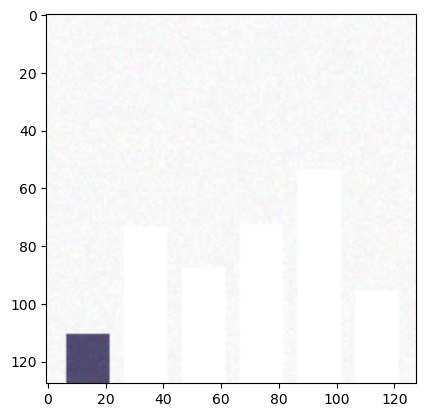

In [21]:
image = plt.imread('test13.png')
#img_arr = np.array(image)
image[54 : 128, 87 : 102] = (1, 1, 1)
image[73 : 128, 67 : 82] = (1, 1, 1)
image[74 : 128, 27 : 42] = (1, 1, 1)
image[88 : 128, 47 : 62] = (1, 1, 1)
image[96 : 128, 107 : 122] = (1, 1, 1)

# Creating an image out of the previously modified array
#img = Image.fromarray(img_arr)
  
# Displaying the image
plt.imshow(image)

In [103]:
def drawImage(self, image, bars, height, width, mask=False):
        
        for bar in bars:
            sx, sy, ex, ey = bar[2]
            if mask== False:
                color = bar[1]
            else:
                color = 1
            cv2.rectangle(image,(sx,sy),(ex,ey),color,-1)
        if mask is False:
            channel  = 3
            noises = np.random.uniform(0, 0.05, (height, width,channel))
            image = image + noises
            _min = 0.0
            _max = image.max()
            image -= _min
            image /= (_max - _min)
        
        return image * 255
        

In [56]:
image.shape

(128, 128, 3)

In [86]:
r

{'rois': array([[ 73,  88, 128, 110],
        [ 57,  21, 128,  40],
        [ 38,  64, 128,  87],
        [  0,  46, 120,  62],
        [ 73, 112, 128, 124],
        [  2,  43,  34,  62],
        [ 36,   2, 128,  17],
        [  0,  62,  33,  89]], dtype=int32),
 'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 'scores': array([1.        , 1.        , 1.        , 1.        , 0.99995804,
        0.99994206, 0.9855789 , 0.9850971 ], dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False